**Introduction**

This notebook uses vehicle silhouette information to detect vehicles of 4 categories:
'van', 'saab', 'bus', 'opel'. 

**Steps:**
1. Loading the data
2. Exploratory Analysis
3. Data preprocessing
    - Removing outliers from the data
4. Training and Testing a classifier (SVM - Support Vector Machine)
5. Hyperparameter Tuning
    - GridCV Search
6. Feature Engineering
    - MinMaxScaler
    - StandardScaler
7. Training and Testing a classifier (SVM - Support Vector Machine)
8. Evaluation Metrics

**Methodology and Result** 

I tried using other ML algorithms as well such as Randorm Forest and Decision Trees but I got better result using SVM so I chose this one. And here is the result of various combinations.

***1. Without Fixing Outliers***
- Experiment I
    - Hyperparameter tuning: N
    - Feature Transformation: N
    - Accuracy: 24%

***2. After Fixing Outliers***

Outlier Handling Method: In order to use a conservative approach, I replaced all the outliers greater than max value for a column with the mean value of the column.

- Experiment II
    - Hyperparameter tuning: N 
    - Feature Transformation(Standard Scaler): Y
    - Accuracy: 72%

- Experiment III
    - Hyperparameter tuning: N 
    - Feature Transformation(MinMaxScaler): Y
    - Accuracy: 61%
    
- Experiment IV
    - Hyperparameter tuning: Y 
    - Feature Transformation(MinMaxScaler): Y
    - Accuracy: 76%
- Experiment V
    - Hyperparameter tuning: Y 
    - Feature Transformation(Standard Scaler): Y
    - Accuracy: 75% 

**Test Train Split Ratio**
I have decided to use 60/40 (Train/Test) ratio based on the result of test-train-split experiment in issue #3 and found out that the choice of the ratio had impact on the accuracy. The test results showed that 60/40(Train/Test) was the optimal ratio for the current dataset and settings.

**Things that didnot work:**
    1. Feature Engineering : 
        Dimensionality Reduction using PCA: I also used PCA but it did not improve the accuracy so I removed that step from this notebook.
        
**Todo**
1. Feature Selection: Since PCA did not work for this data set, I will try other methods to select the relevant features and check if it improves the model's accuracy

**References:**
1. https://www.kaggle.com/yamitkumar/kernel4903101945
2. https://scikit-learn.org/stable/supervised_learning.html
3. https://scikit-learn.org/stable/modules/model_evaluation.html

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
pd.set_option("display.precision", 2) 

In [2]:
df = pd.read_csv("../../datasets/vehicles.csv")

Next we will explore the following aspects of the data:
1. Data type
2. Null Columns (if any)
3. Outliers
4. Correlation among features

In [3]:
df['Class'].unique()

array(['van', 'saab', 'bus', 'opel'], dtype=object)

In [4]:
df.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   COMPACTNESS                846 non-null    int64 
 1   CIRCULARITY                846 non-null    int64 
 2   DISTANCE_CIRCULARITY       846 non-null    int64 
 3   RADIUS_RATIO               846 non-null    int64 
 4   PR.AXIS_ASPECT_RATIO       846 non-null    int64 
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    int64 
 6   SCATTER_RATIO              846 non-null    int64 
 7   ELONGATEDNESS              846 non-null    int64 
 8   PR.AXIS_RECTANGULARITY     846 non-null    int64 
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    int64 
 10  SCALED_VARIANCE_MAJOR      846 non-null    int64 
 11  SCALED_VARIANCE_MINOR      846 non-null    int64 
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    int64 
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    int64 
 14  SKEWNESS_A

In [6]:
feature_cols = ['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR']
label_col = ['Class']

In [7]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,93.68,8.23,73.0,87.00,93.0,100.0,119.0
CIRCULARITY,846.0,44.86,6.17,33.0,40.00,44.0,49.0,59.0
DISTANCE_CIRCULARITY,846.0,82.09,15.77,40.0,70.00,80.0,98.0,112.0
RADIUS_RATIO,846.0,168.94,33.47,104.0,141.00,167.0,195.0,333.0
PR.AXIS_ASPECT_RATIO,846.0,61.69,7.89,47.0,57.00,61.0,65.0,138.0
MAX.LENGTH_ASPECT_RATIO,846.0,8.57,4.60,2.0,7.00,8.0,10.0,55.0
SCATTER_RATIO,846.0,168.84,33.24,112.0,146.25,157.0,198.0,265.0
ELONGATEDNESS,846.0,40.93,7.81,26.0,33.00,43.0,46.0,61.0
PR.AXIS_RECTANGULARITY,846.0,20.58,2.59,17.0,19.00,20.0,23.0,29.0
MAX.LENGTH_RECTANGULARITY,846.0,148.00,14.52,118.0,137.00,146.0,159.0,188.0


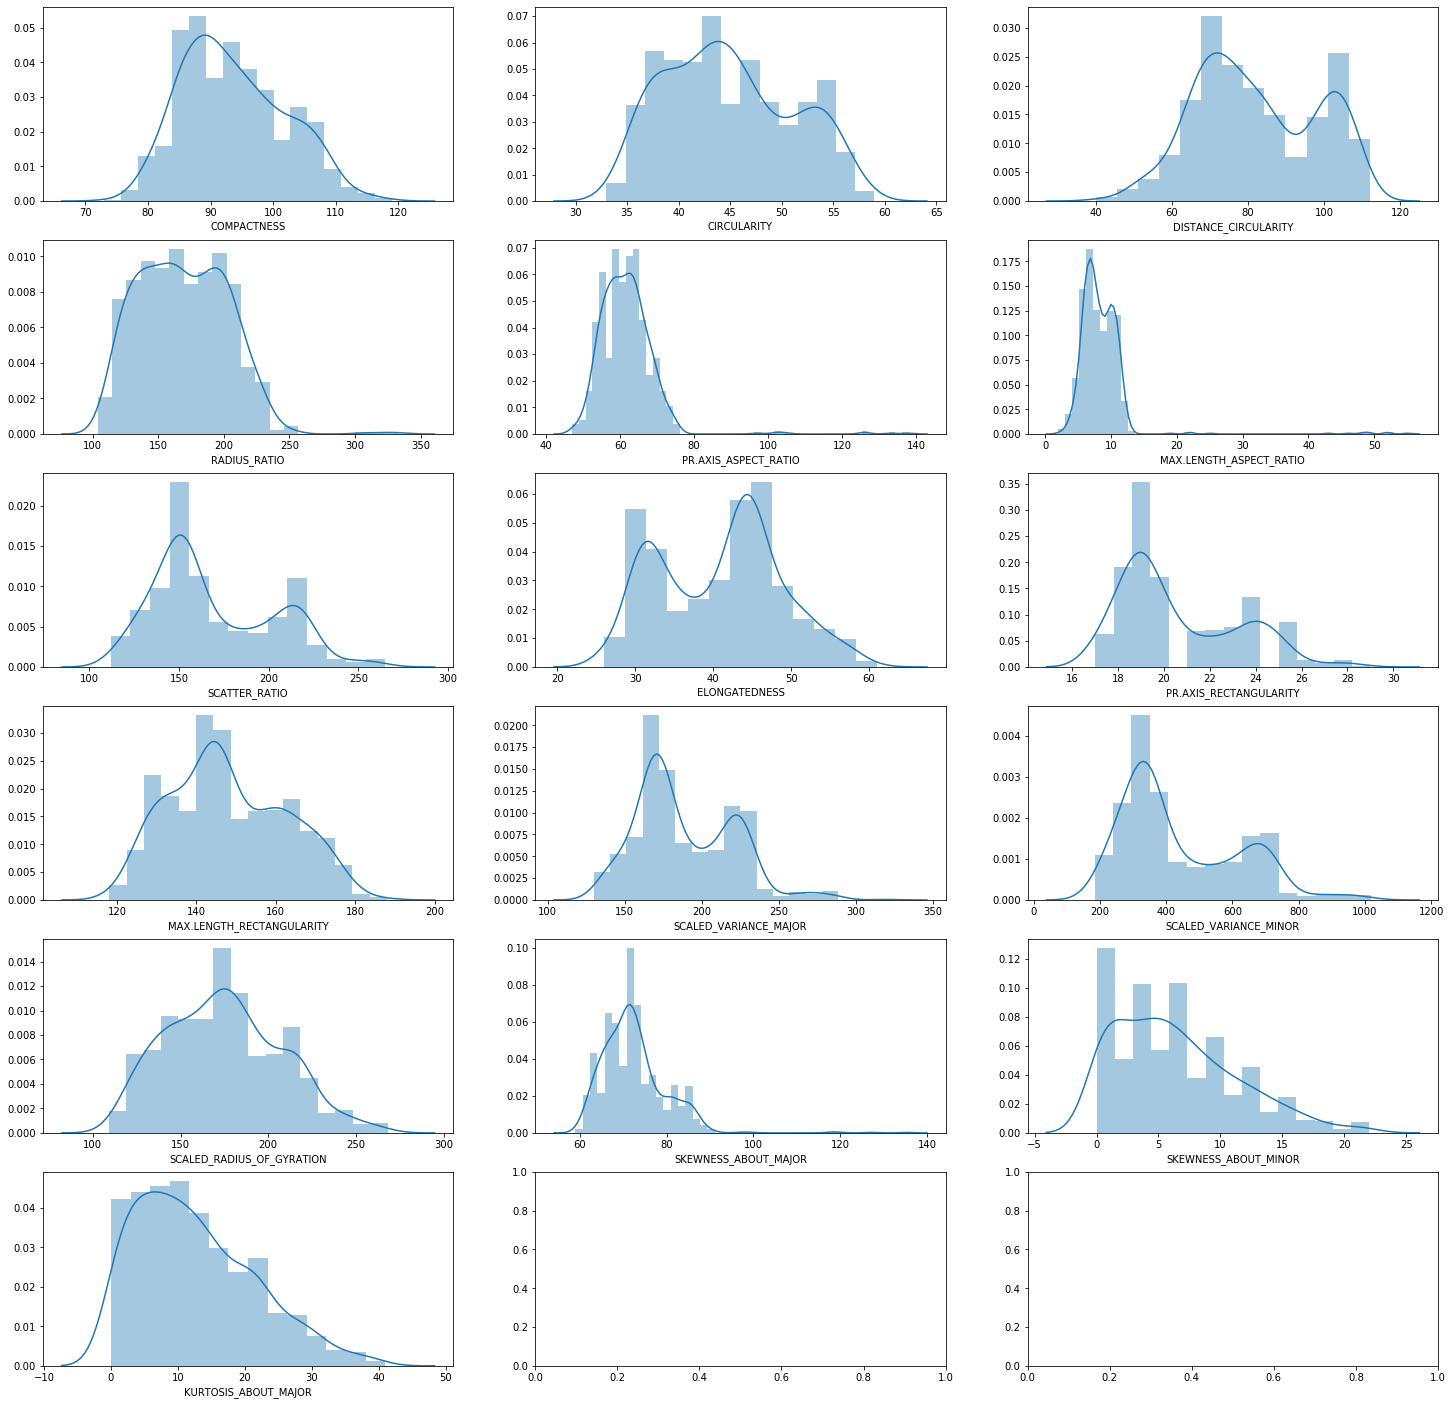

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.distplot(df[column],ax=axes[i//3,i%3])

In [9]:
df['Class'].unique()

array(['van', 'saab', 'bus', 'opel'], dtype=object)

**Data Insight**

The data looks clean as there are no null values out of total 846 entries. All of the fields are of integer types. The last column is the target value which will be used as label. There are four vehicle categories: 'van', 'saab', 'bus', 'opel'. This is multi-class classifcation problem.

From above statistics, Standard deviation(scatteredness) seems high for SCALED_VARIANCE_MINOR field. For other mean and standard deviation looks fine. And the distribution for each feature has many variations : unimodal, bimodal and multimodal. 

There are few outliers in some features such as : 
MAX.LENGTH_ASPECT_RATIO, SKEWNESS_ABOUT_MAJOR. 

Since we have outliers in our data, lets create boxplot graph to identify min, max values and outliers.

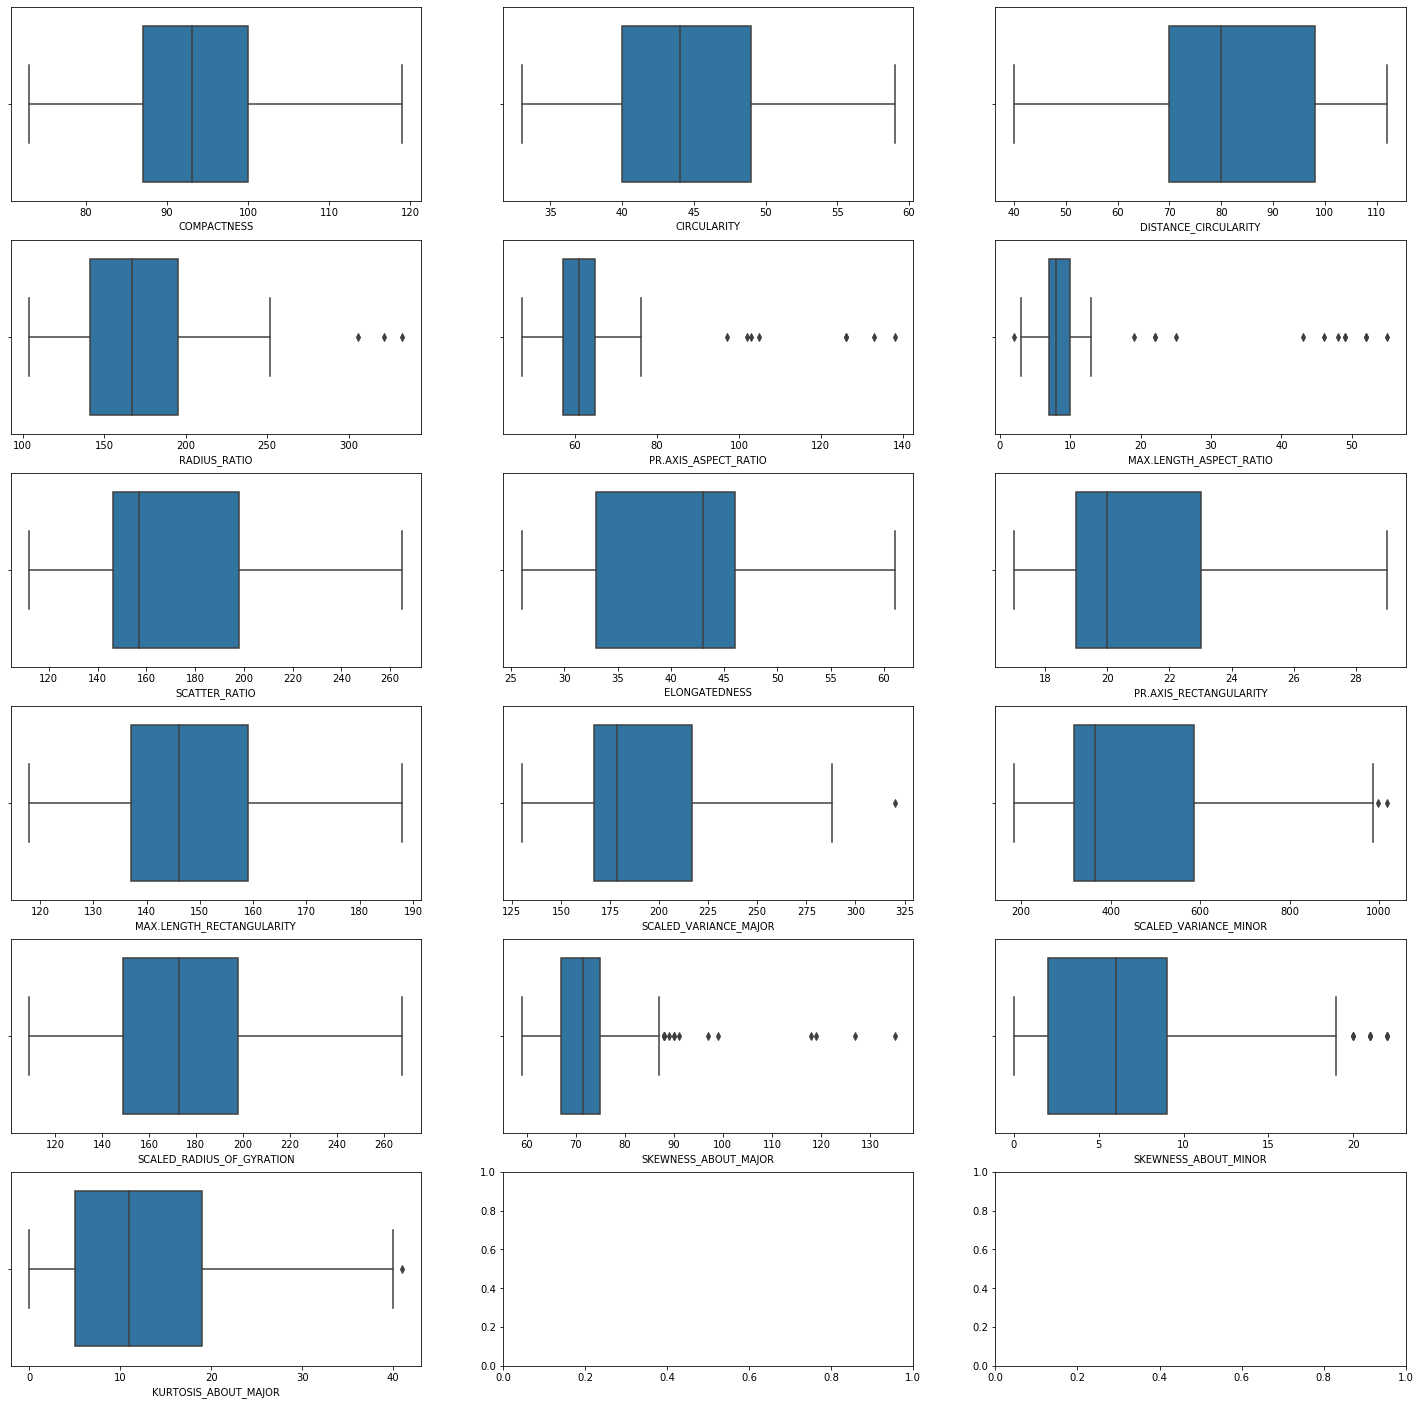

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.boxplot(df[column],ax=axes[i//3,i%3], dodge=False, whis=1.5)

**Fixing Outliers**

Based on the above graph, these are the features/columns that have outliers:

1. RADIUS_RATIO
2. PR.AXIS_ASPECT_RATIO
3. MAX.LENGTH_ASPECT_RATIO
4. SCALED_VARIANCE_MAJOR
5. SCALED_VARIANCE_MINOR
6. SKEWNESS_ABOUT_MAJOR
7. SKEWNESS_ABOUT_MINOR
8. KURTOSIS_ABOUT_MAJOR

We will fix all the rows that have outliers by replacing outliers > max by max value(of that column/feature) because outliers in data can result in inaccurate models.

There are 51 rows with outliers out of 846 rows.

In [11]:
# Max value based on boxplot to filter outliers of 8 columns where outliers are identified. 
df_columns_with_outliers = pd.DataFrame([[255, 77, 13, 288, 980, 88, 19, 40]], columns=['RADIUS_RATIO', 
                                                                                'PR.AXIS_ASPECT_RATIO', 
                                                                                'MAX.LENGTH_ASPECT_RATIO', 
                                                                                'SCALED_VARIANCE_MAJOR', 
                                                                                'SCALED_VARIANCE_MINOR', 
                                                                                'SKEWNESS_ABOUT_MAJOR', 
                                                                                'SKEWNESS_ABOUT_MINOR', 
                                                                                'KURTOSIS_ABOUT_MAJOR'])

total_outliers = 0
for i, column in enumerate(df_columns_with_outliers.columns):
    total_outliers += df[column][df[column] > df_columns_with_outliers[column][0]].size
print(len(df.index))
print('Total Outliers ', total_outliers)

846
Total Outliers  51


In [12]:
from helpers import fix_outlier_with_mean, fix_outlier_with_boundary_value

# Outliers handling by replacing outliers by mean
df_new = fix_outlier_with_mean(df, df_columns_with_outliers)

df_new.info()
df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMPACTNESS                846 non-null    int64  
 1   CIRCULARITY                846 non-null    int64  
 2   DISTANCE_CIRCULARITY       846 non-null    int64  
 3   RADIUS_RATIO               846 non-null    float64
 4   PR.AXIS_ASPECT_RATIO       846 non-null    float64
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    float64
 6   SCATTER_RATIO              846 non-null    int64  
 7   ELONGATEDNESS              846 non-null    int64  
 8   PR.AXIS_RECTANGULARITY     846 non-null    int64  
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    int64  
 10  SCALED_VARIANCE_MAJOR      846 non-null    float64
 11  SCALED_VARIANCE_MINOR      846 non-null    float64
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    int64  
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    float64

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178.0,72.00,10.00,162,42,20,159,176.0,379.0,184,70.00,6.0,16.0,187,197,3
1,91,41,84,141.0,57.00,9.00,149,45,19,143,170.0,330.0,158,72.00,9.0,14.0,189,199,3
2,104,50,106,209.0,66.00,10.00,207,32,23,158,223.0,635.0,220,73.00,14.0,9.0,188,196,2
3,93,41,82,159.0,63.00,9.00,144,46,19,143,160.0,309.0,127,63.00,6.0,10.0,199,207,3
4,85,44,70,205.0,61.17,8.11,149,45,19,144,241.0,325.0,188,72.07,9.0,11.0,180,183,0


***Redrawing the plots to see the outliers again***

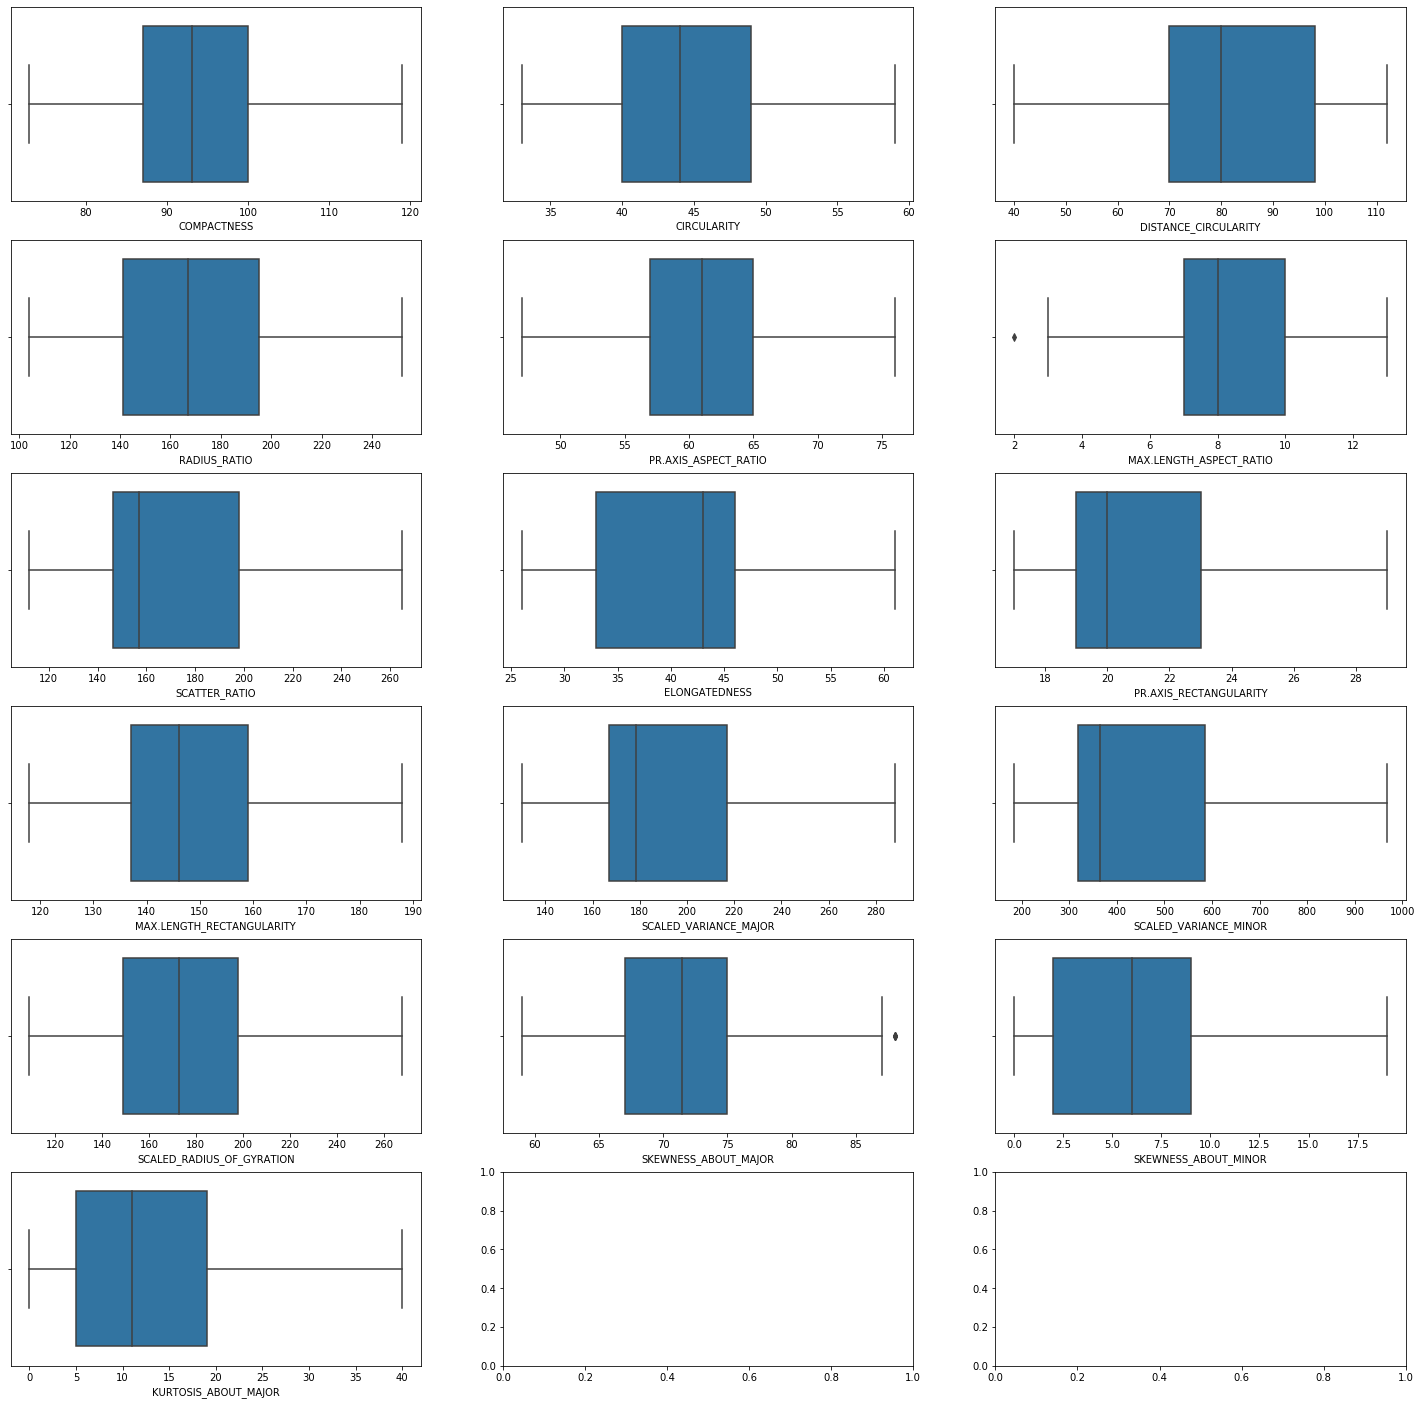

In [13]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.boxplot(df_new[column],ax=axes[i//3,i%3], dodge=False, whis=1.5)

**Post Outlier Fixing**

I did not remove the outlier instead I used the conservative approach. After outlier fix, the rows count are same. We can see no outliers in the above boxplot, except 2 outliers in two different columns.

**Check Correlation Among Features**

Next step is to check the correlation among the features so that we can use some dimensionality reduction techniques such as PCA. I am using pearson coefficient method to calculate the correlation.

The are more than 9 features which have >.8 corrrelation wih other features. 

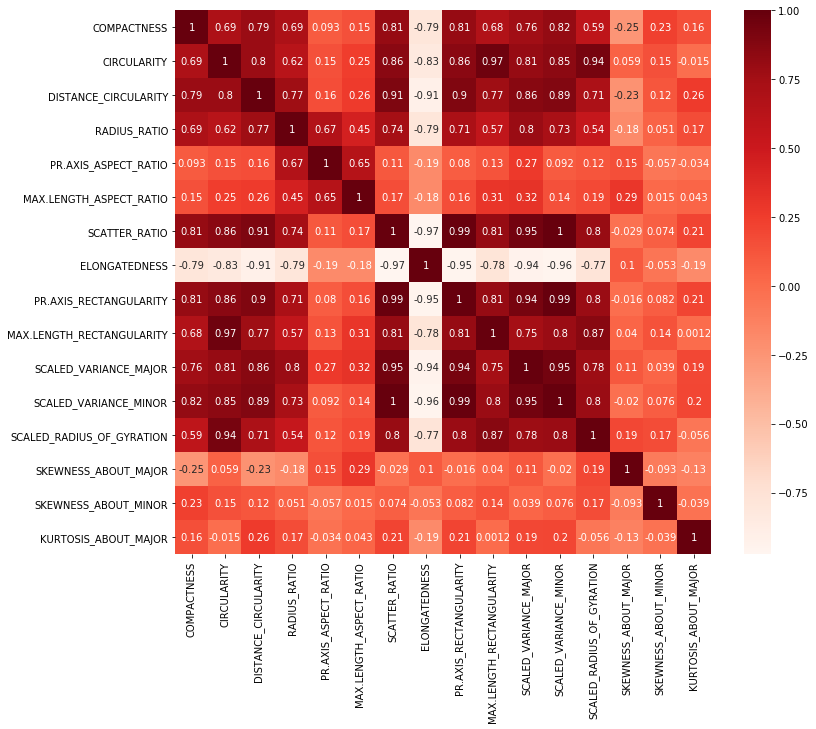

In [14]:
# Using Pearson Correlation

plt.figure(figsize=(12,10))
corr_matrix = df[feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

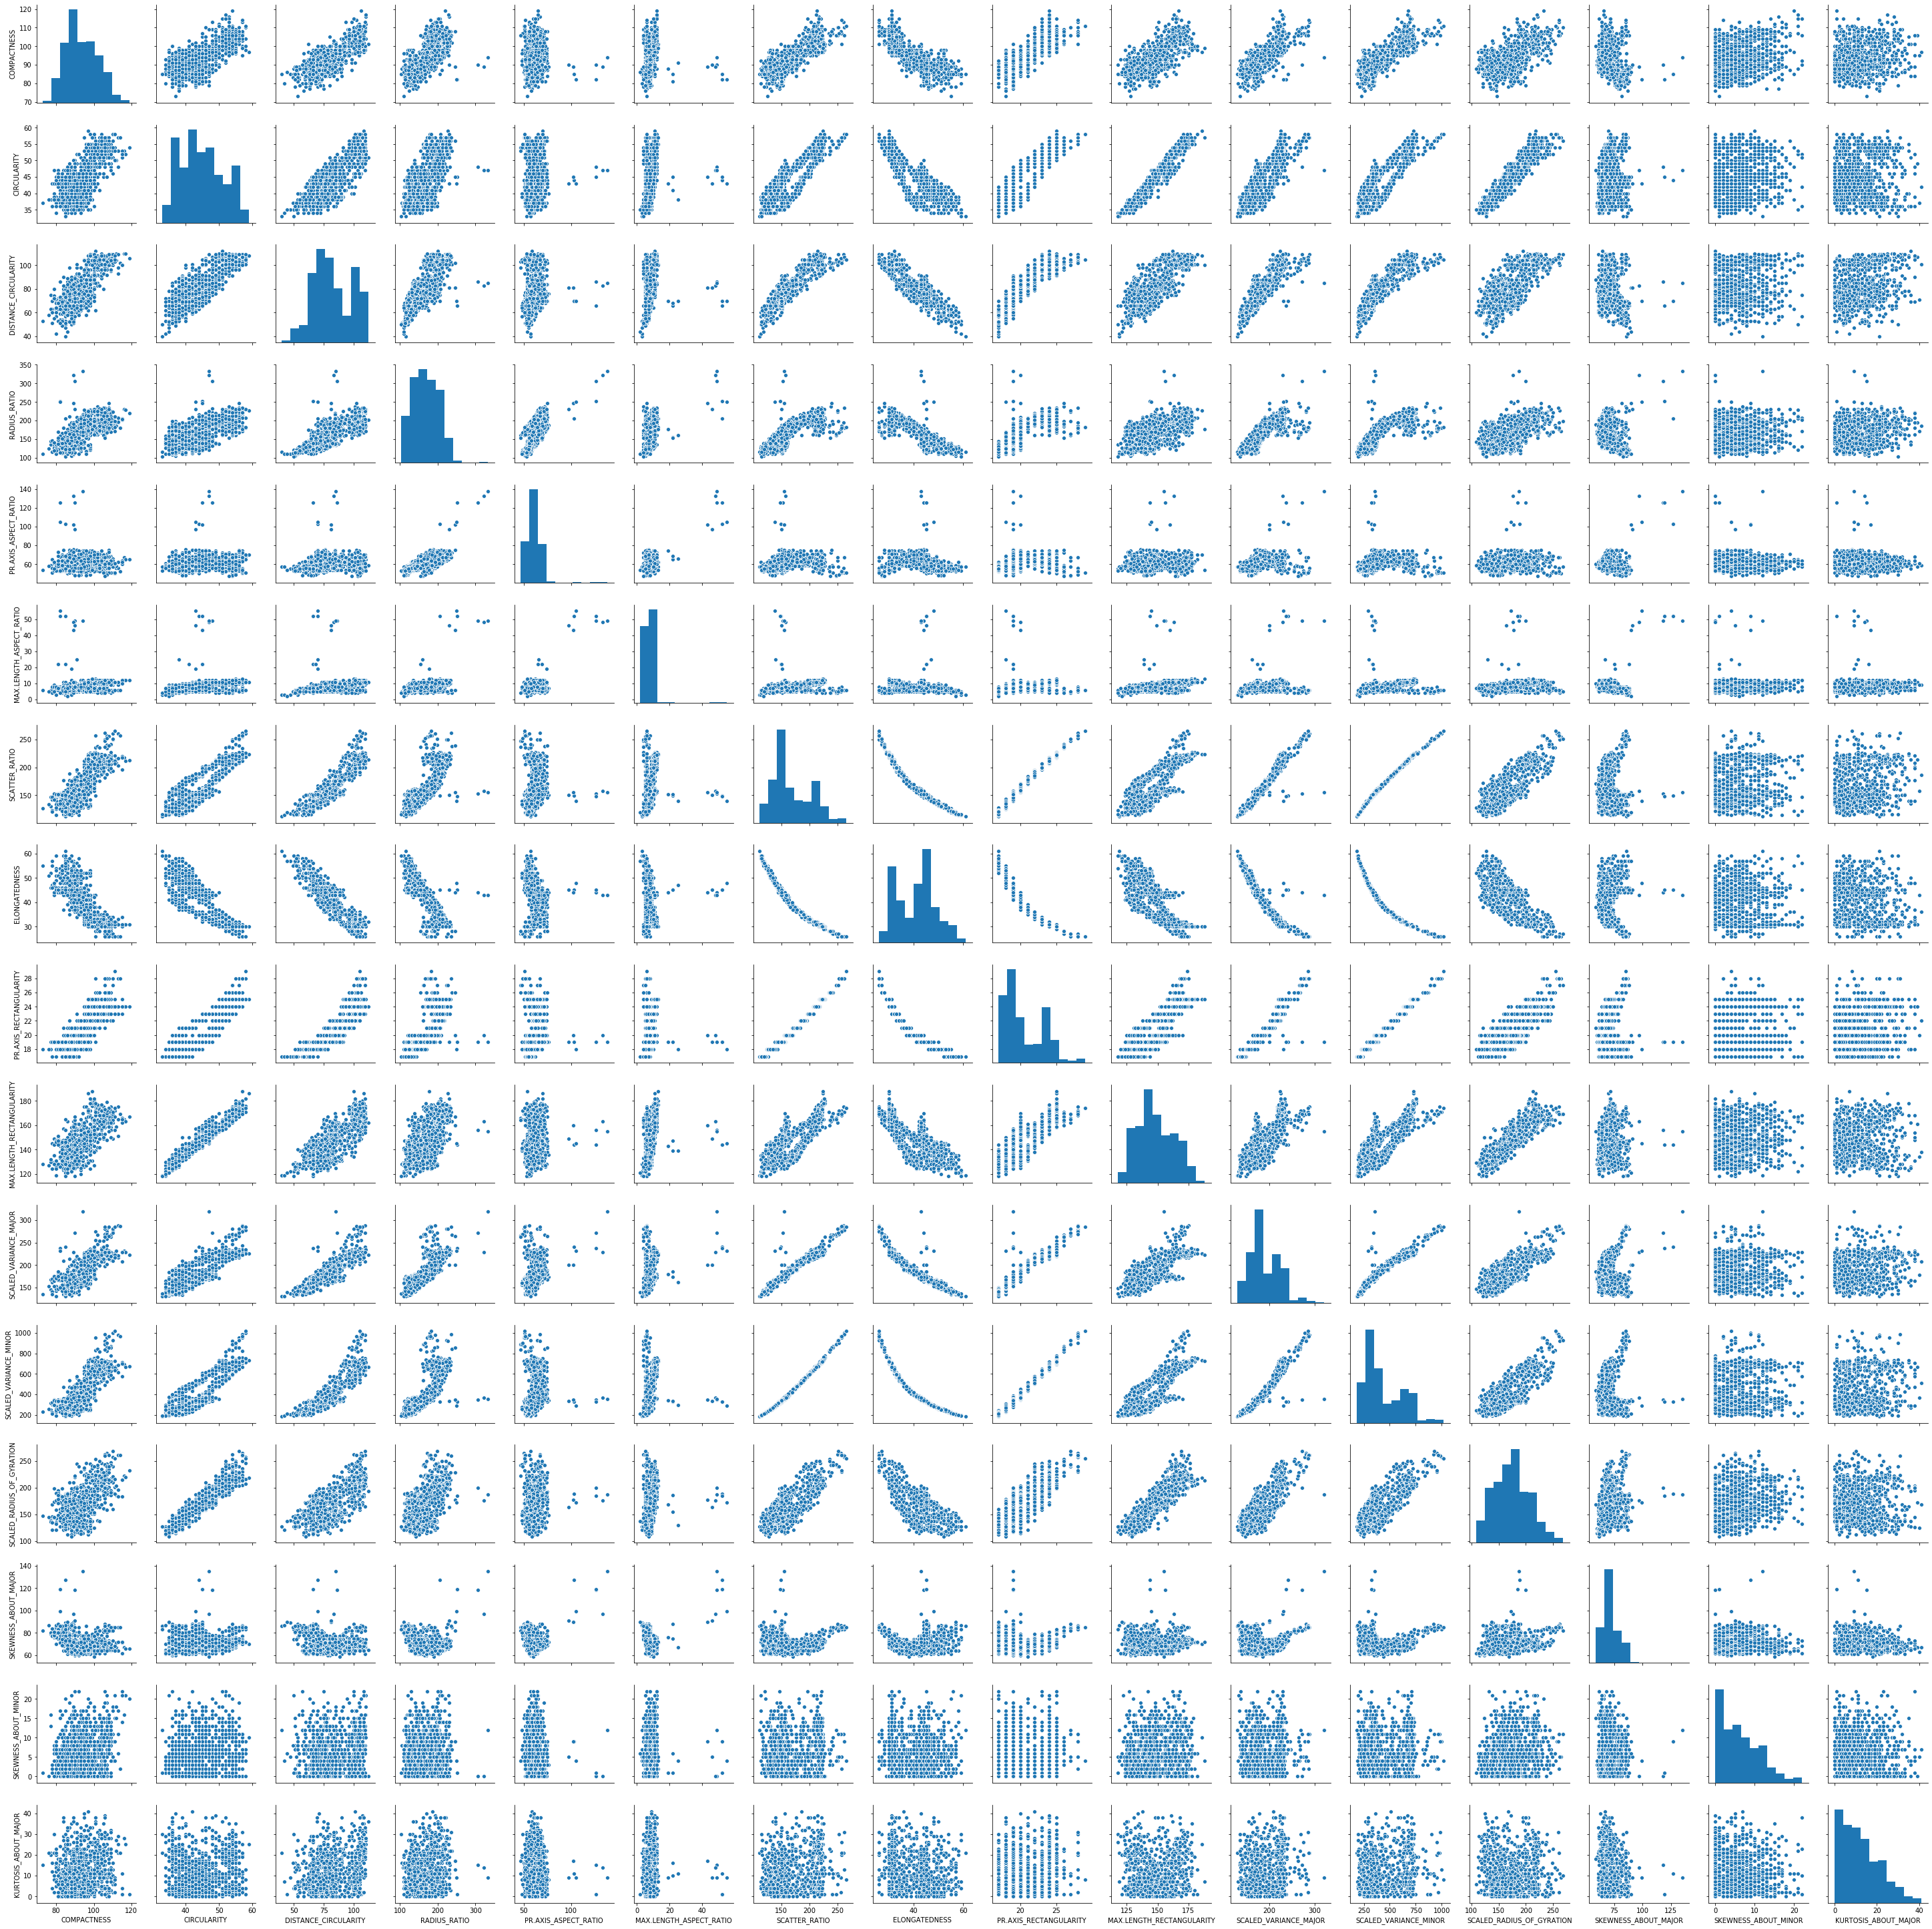

In [15]:
# Scatter plot matrix
#%config InlineBackend.figure_format = 'png'
sns.pairplot(df[feature_cols]);

**PCA Application Result**

Based on the above correlation info, I tried using PCA combined with data transformation(Standard Scaler) but it did not improve the accuracy of the model with current settings. But I will retry using it later with different settings.

**Training and Testing the Model**

I will use 4 different combinations for training and testing the model:


***1. Without Fixing Outliers***
- Experiment I
    - Hyperparameter tuning: N
    - Feature Transformation: N
    
***2. Fixing Outliers***
Outlier Handling Method: In order to use a conservative approach, I replaced all the outliers greater than max value for a column with the mean value of the column.

- Experiment II
    - Hyperparameter tuning: N
    - Feature Transformation(Standard Scaler): Y
- Experiment III
    - Hyperparameter tuning: N 
    - Feature Transformation(MinMaxScaler): Y
- Experiment IV
    - Hyperparameter tuning: Y 
    - Feature Transformation(MinMaxScaler): Y
- Experiment V
    - Hyperparameter tuning: Y 
    - Feature Transformation(Standard Scaler): Y

**Test Train Split Ratio**
I have decided to use 60/40 (Train/Test) ratio based on the result of test-train-split experiment in issue #3 and found out that the choice of the ratio had impact on the accuracy. The test results showed that 60/40(Train/Test) was the optimal ratio for the current dataset and settings.

**Experiment I**

In [16]:
from helpers import train_svm, print_results

X = df[feature_cols]
y = df[label_col]
y_test, y_pred = train_svm(X, y.values.ravel())
print_results(y_test, y_pred)

Accuracy: 0.2448377581120944
[[82  0  0  0]
 [92  0  0  0]
 [86  0  0  0]
 [78  0  0  1]]
              precision    recall  f1-score   support

         bus       0.24      1.00      0.39        82
        opel       0.00      0.00      0.00        92
        saab       0.00      0.00      0.00        86
         van       1.00      0.01      0.02        79

    accuracy                           0.24       339
   macro avg       0.31      0.25      0.10       339
weighted avg       0.29      0.24      0.10       339



/home/shashig/anaconda3/envs/presc/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Experiment II: StandardScaler without hyperparameter tuning**

In [17]:
from sklearn.preprocessing import StandardScaler

X_new = df_new[feature_cols]
y_new = df_new[label_col]

# intialize StandardScaler
scaler_sc = StandardScaler()

y_test, y_pred = train_svm(X_new, y_new.values.ravel(), scaler_sc)
print_results(y_test, y_pred)

<class 'sklearn.preprocessing.data.StandardScaler'>
Accuracy: 0.7256637168141593
[[81  0  0  1]
 [ 0 31 55  6]
 [ 4 18 59  5]
 [ 3  1  0 75]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        82
           1       0.62      0.34      0.44        92
           2       0.52      0.69      0.59        86
           3       0.86      0.95      0.90        79

    accuracy                           0.73       339
   macro avg       0.73      0.74      0.72       339
weighted avg       0.72      0.73      0.71       339



**Experiment III: MinMaxScaler without hyperparameter tuning**

In [18]:
from sklearn.preprocessing import MinMaxScaler

X_new = df_new[feature_cols]
y_new = df_new[label_col]

# intialize MinMaxScaler
scaler_mm = MinMaxScaler(feature_range=[0, 1])

y_test, y_pred = train_svm(X_new, y_new.values.ravel(), scaler_mm)
print_results(y_test, y_pred)

<class 'sklearn.preprocessing.data.MinMaxScaler'>
Accuracy: 0.6106194690265486
[[77  0  0  5]
 [ 9  0 62 21]
 [14  1 56 15]
 [ 4  0  1 74]]
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        82
           1       0.00      0.00      0.00        92
           2       0.47      0.65      0.55        86
           3       0.64      0.94      0.76        79

    accuracy                           0.61       339
   macro avg       0.46      0.63      0.53       339
weighted avg       0.45      0.61      0.52       339



**Hyperparameter Tuning**

I am using GridSearchCV function to find the optimal parameters i.e parameter tuning. I will be using rbf(Radial basis kernel). The optimal params value  for c and gamma was based on this kaggle kernel (https://www.kaggle.com/rajansharma780/vehicle/kernels).


**Experiment IV: Hyperparameter Tuning with MinMaxScaler**

In [19]:
from helpers import train_svm_with_hyperparameter_tuning

X_new = df_new[feature_cols]
y_new = df_new[label_col]

# intialize MinMaxScaler
scaler_mm = MinMaxScaler(feature_range=[0, 1])

# Parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

y_test, y_pred = train_svm_with_hyperparameter_tuning(X_new, y_new.values.ravel(), param_grid, scaler_mm)

<class 'sklearn.preprocessing.data.MinMaxScaler'>
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.665, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.639, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.643, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.288, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.320, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.286, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ..

/home/shashig/anaconda3/envs/presc/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.271, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.266, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.268, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.271, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.266, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.268, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.806, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


In [20]:
print_results(y_test, y_pred)

Accuracy: 0.7669616519174042
[[82  0  0  0]
 [ 0 54 37  1]
 [ 2 30 52  2]
 [ 2  3  2 72]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        82
           1       0.62      0.59      0.60        92
           2       0.57      0.60      0.59        86
           3       0.96      0.91      0.94        79

    accuracy                           0.77       339
   macro avg       0.78      0.78      0.78       339
weighted avg       0.77      0.77      0.77       339



**Experiment V: Hyperparameter Tuning with StandardScaler**

In [21]:
X_new = df_new[feature_cols]
y_new = df_new[label_col]

# intialize StandardScaler
scaler_sc = StandardScaler()

# Parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
y_test, y_pred = train_svm_with_hyperparameter_tuning(X_new, y_new.values.ravel(), param_grid, scaler_sc)

/home/shashig/anaconda3/envs/presc/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


<class 'sklearn.preprocessing.data.StandardScaler'>
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.271, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.266, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.268, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.665, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.633, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.655, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf 

[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.645, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.649, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.782, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.740, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.774, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.829, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.787, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


In [22]:
print_results(y_test, y_pred)

Accuracy: 0.7522123893805309
[[81  1  0  0]
 [ 0 50 40  2]
 [ 2 30 51  3]
 [ 2  2  2 73]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        82
           1       0.60      0.54      0.57        92
           2       0.55      0.59      0.57        86
           3       0.94      0.92      0.93        79

    accuracy                           0.75       339
   macro avg       0.76      0.76      0.76       339
weighted avg       0.75      0.75      0.75       339

